# process the raw data

## clean cols + merge datas + flatten vars

In [1]:
import numpy as np; import pandas as pd
def merge_data(df):
    "merge the times in to a row"
    #'{ 2014-02-17 : {call:22, mood: 44,.. }, ...          }
    item_dict= dict()
    for i in range(df.shape[0]):
    #for time in df.index:
        o_time = df.index[i]; var = str(df.iloc[i,:].variable); val = df.iloc[i,:].value
        time = str(o_time)
        time = time.strip().split()[0]
        item_dict.setdefault(time, []).append((var, val))
    # then merge the same variable in one day
    for time, i_list in item_dict.items():
        # [ 'time' : [ [call,val], ...]
        inter_dict = dict() # { 'call:(sum, number)
        for var, val in i_list:
            if var not in inter_dict:
                inter_dict[var]= [val,1]
            elif var in inter_dict:
                inter_dict[var][0] += val
                inter_dict[var][1] +=1
        'get mean'
        for var,tup in inter_dict.items():
            inter_dict[var] = tup[0]/tup[1]
        item_dict[time] = inter_dict

        del inter_dict
    result = pd.DataFrame(item_dict).T
    result.index = pd.to_datetime(result.index)
    return  result

df = pd.read_csv('/Users/jerryliu/Documents/Vu_uva/p5/data_mining/assignment1/dataset_mood_smartphone.csv')
df = df.drop(['Unnamed: 0', 'id'], axis= 1)

df.index = pd.to_datetime(df.time)
df = df.drop(['time'], axis = 1)

In [2]:
df_merged = merge_data(df)

df_merged = df_merged.sort_index()

## load 'merge.csv', select columns with less NAs.

In [5]:
df_merged = pd.read_csv('merged.csv', index_col= 0)

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpt
for i in df_merged.columns:
    ratio = sum(df_merged.loc[:,i].isnull())/df_merged.shape[0]
        
    if ratio >= 0.3:
        df_merged.drop([i], axis = 1, inplace=True)
        print(i)
    else:
        if i in ['call','sms']:
            df_merged.loc[:,i].fillna(0,inplace = True)
df_merged.fillna(method = 'ffill', inplace=True)
df_merged.fillna(method='bfill', inplace=True)

circumplex.arousal
circumplex.valence
appCat.finance
appCat.office
appCat.travel
appCat.unknown
appCat.utilities
appCat.weather
appCat.game


In [16]:
df_merged.shape


(113, 10)

##[Plot variables]

# plotting

<IPython.core.display.Javascript object>


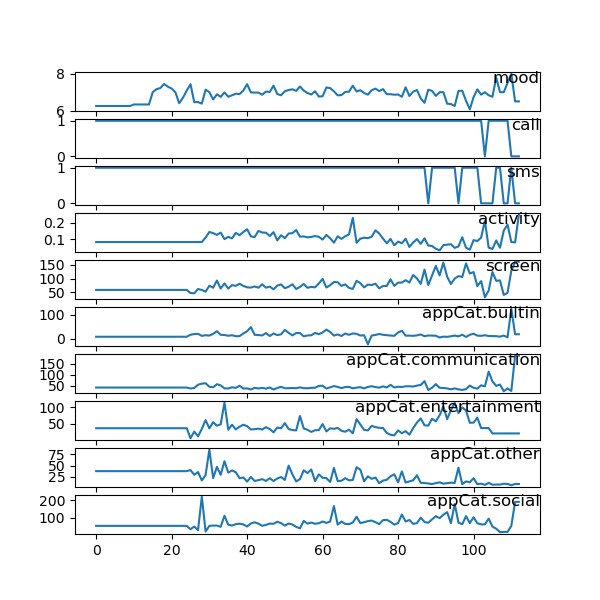

In [65]:
values = df_merged.values
groups = list(range(10))
i = 1
mpt.rcParams['figure.figsize'] = (6,6)
plt.figure()
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:, group])
    plt.title(df_merged.columns[group], y = 0.5, loc = 'right')
    i += 1
plt.show()

# Train On Multiple Lag Timesteps 

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [15]:
dataset = df_merged
values = dataset.values
# ensure all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_days = 3
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(110, 40)


In [50]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
3,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739,...,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739
4,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739,...,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739
5,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739,...,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739
6,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739,...,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739
7,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739,...,0.094828,1.0,1.0,0.232343,0.207673,0.211700,0.104493,0.281576,0.396107,0.178739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.353448,1.0,0.0,0.038046,0.711806,0.230022,0.276633,0.135006,0.014679,0.159874,...,0.482759,1.0,0.0,0.554677,0.066302,0.244629,0.000000,0.135006,0.041169,0.009210
109,0.896552,1.0,1.0,0.277126,0.463328,0.227943,0.151777,0.135006,0.019043,0.098598,...,0.741379,1.0,0.0,0.724007,0.125959,0.194411,0.080143,0.135006,0.036513,0.009210
110,0.482759,1.0,1.0,0.071504,0.474586,0.214387,0.188634,0.135006,0.019470,0.000000,...,1.000000,0.0,1.0,0.233424,0.746307,1.000000,0.008304,0.135006,0.000000,0.177989
111,0.482759,1.0,0.0,0.554677,0.066302,0.244629,0.000000,0.135006,0.041169,0.009210,...,0.224138,0.0,0.0,0.222557,1.000000,0.282010,1.000000,0.135006,0.035641,0.853416


In [55]:
# split into train and test sets
values = reframed.values
n_train_days = 60
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [56]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [57]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#test_X.shape

(60, 3, 10) (60,) (50, 3, 10) (50,)


Epoch 1/50
1/1 - 2s - loss: 0.4964 - val_loss: 0.5042
Epoch 2/50
1/1 - 0s - loss: 0.4601 - val_loss: 0.4684
Epoch 3/50
1/1 - 0s - loss: 0.4239 - val_loss: 0.4341
Epoch 4/50
1/1 - 0s - loss: 0.3879 - val_loss: 0.4001
Epoch 5/50
1/1 - 0s - loss: 0.3520 - val_loss: 0.3667
Epoch 6/50
1/1 - 0s - loss: 0.3162 - val_loss: 0.3343
Epoch 7/50
1/1 - 0s - loss: 0.2857 - val_loss: 0.3044
Epoch 8/50
1/1 - 0s - loss: 0.2601 - val_loss: 0.2771
Epoch 9/50
1/1 - 0s - loss: 0.2397 - val_loss: 0.2518
Epoch 10/50
1/1 - 0s - loss: 0.2214 - val_loss: 0.2271
Epoch 11/50
1/1 - 0s - loss: 0.2044 - val_loss: 0.2028
Epoch 12/50
1/1 - 0s - loss: 0.1887 - val_loss: 0.1807
Epoch 13/50
1/1 - 0s - loss: 0.1744 - val_loss: 0.1615
Epoch 14/50
1/1 - 0s - loss: 0.1626 - val_loss: 0.1461
Epoch 15/50
1/1 - 0s - loss: 0.1536 - val_loss: 0.1372
Epoch 16/50
1/1 - 0s - loss: 0.1492 - val_loss: 0.1343
Epoch 17/50
1/1 - 0s - loss: 0.1483 - val_loss: 0.1332
Epoch 18/50
1/1 - 0s - loss: 0.1517 - val_loss: 0.1363
Epoch 19/50
1/1 - 0

<IPython.core.display.Javascript object>


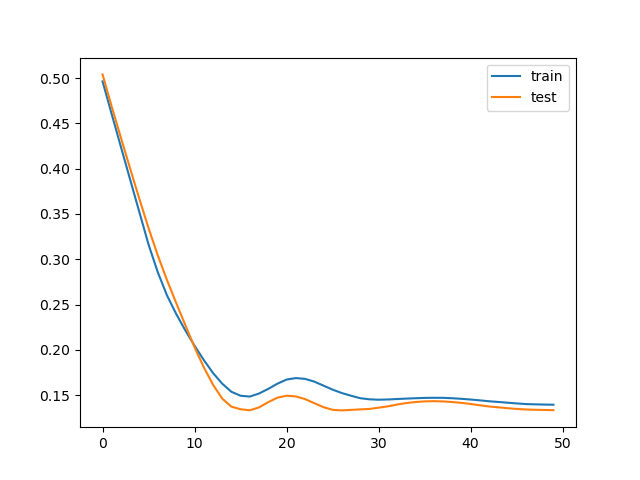

In [58]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
%matplotlib notebook
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [59]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.380


<IPython.core.display.Javascript object>


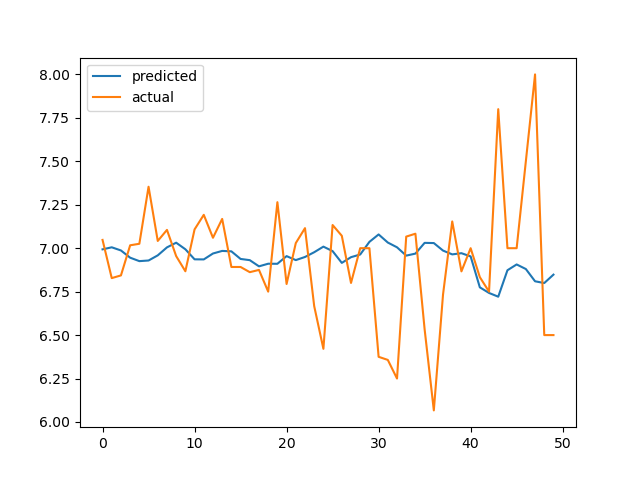

In [60]:
%matplotlib notebook
plt.plot(inv_yhat, label = 'predicted')
plt.plot(inv_y, label = 'actual')
plt.legend()
plt.show()